# CVAE

In [1]:
from pathlib import Path

import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

import matplotlib.pyplot as plt
import numpy as np

import pmldiku
from pmldiku import data, vae, model_utils

%load_ext autoreload
%autoreload 1
%aimport pmldiku.data, pmldiku.vae, pmldiku.model_utils

In [3]:
torch.manual_seed(1)

CUDA = True
BATCH_SIZE = 128
LOGPX_LOSS = "mse"
DEVICE_NAME = "cuda" if CUDA else "cpu"

DEVICE = torch.device(DEVICE_NAME)
kwargs = {'num_workers': 4, 'pin_memory': DEVICE} 

In [4]:
# Val equals test here :)
train_loader = data.load_mnist(train=True).setup_data_loader(batch_size=BATCH_SIZE, **kwargs)
val_loader = data.load_mnist(train=False).setup_data_loader(batch_size=BATCH_SIZE, **kwargs)  

# Train model

In [5]:
# Model
base_vae = vae.CVAE(hidden_dim=2)
model = vae.LitVAE(vae=base_vae, logpx_loss=LOGPX_LOSS)

# Callbacks
loss_callback = vae.VAELossCallback()
reconstruct_cb = vae.VAEImageReconstructionCallback()
cb_checkpoint = ModelCheckpoint(
    dirpath=pmldiku.FP_MODELS,
    filename='mnist-CVAE-MSE-{epoch:02d}-{val_loss:.2f}'
)
cb_earlystopping = EarlyStopping(monitor="val_loss", mode="min")
callbacks = [loss_callback, reconstruct_cb, cb_checkpoint, cb_earlystopping]

# Trainer
trainer = pl.Trainer(max_epochs=-1, devices=1, accelerator=DEVICE_NAME, callbacks=callbacks)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [6]:
trainer.fit(model=model, train_dataloaders=train_loader, val_dataloaders=val_loader)

/scratch/fjr906/miniconda3/envs/pml/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:604: UserWarning: Checkpoint directory /scratch/fjr906/projects/pml/pmldiku-exam-paper/code/models exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]

  | Name | Type | Params
------------------------------
0 | vae  | CVAE | 96.7 K
------------------------------
96.7 K    Trainable params
0         Non-trainable params
96.7 K    Total params
0.387     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

array([23586.10351562,  5491.29541016,  5273.70068359,  5199.05761719,
        5199.10107422,  5143.44287109,  5122.66210938,  5079.65087891,
        5044.91162109,  5012.50292969,  5003.6484375 ,  4991.56494141,
        4969.23779297,  4991.97167969,  4939.79833984,  4948.41601562,
        4928.6796875 ,  4933.07666016,  4921.39697266,  4928.09667969,
        4909.54052734,  4900.63378906,  4892.77099609,  4897.63037109,
        4901.72900391,  4918.30566406])

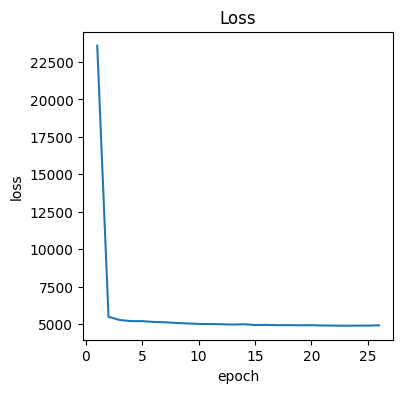

In [7]:
losses = np.array(loss_callback.val_loss)
model_utils.plot_loss(losses)
losses

# Reconstruction of model for each epoch of training

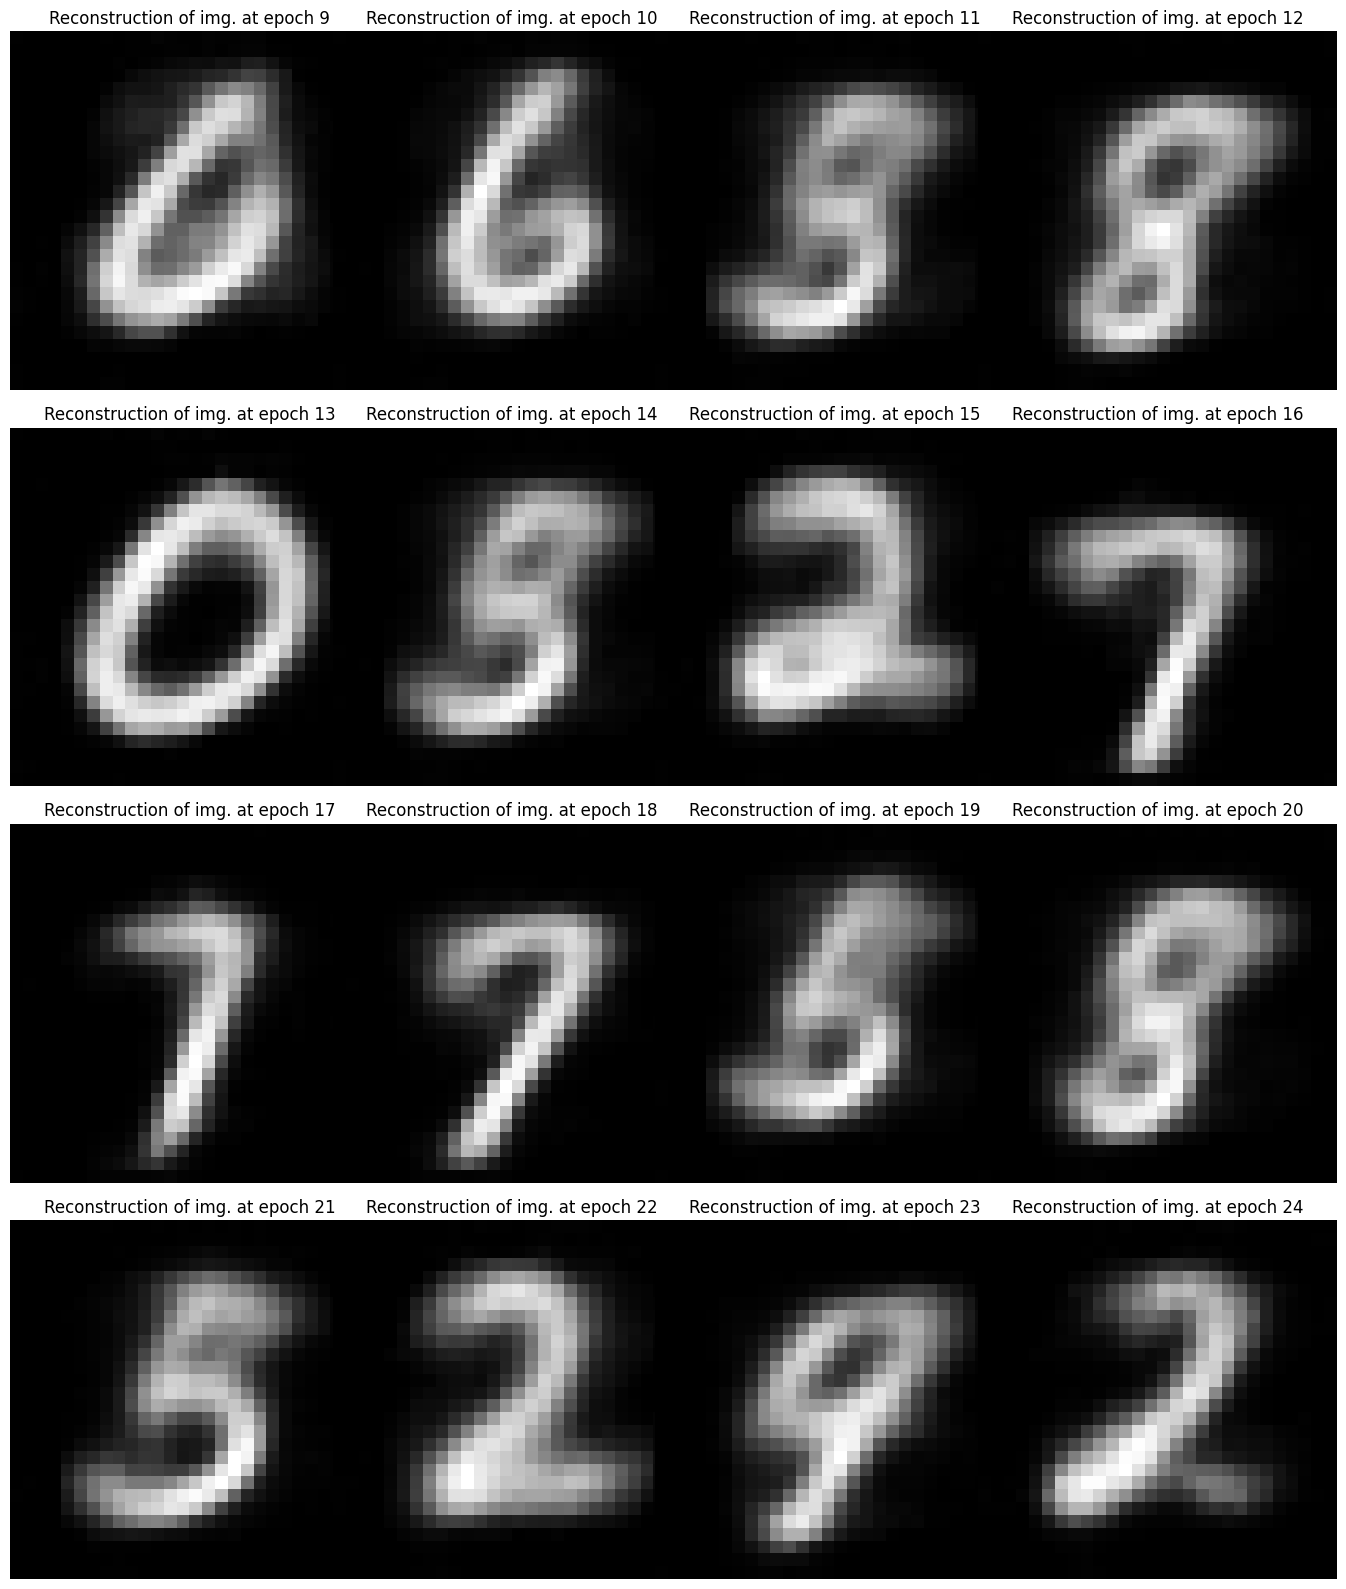

In [8]:
# Take first image of each batch of reconstructed images
images = reconstruct_cb.samples[-16:, 0, :, :].cpu().numpy()
start = cb_earlystopping.stopped_epoch - 16
model_utils.plot_image_reconstruction(images, num_cols=4, slim=20, start=start)

# Expected value in latent space for each number

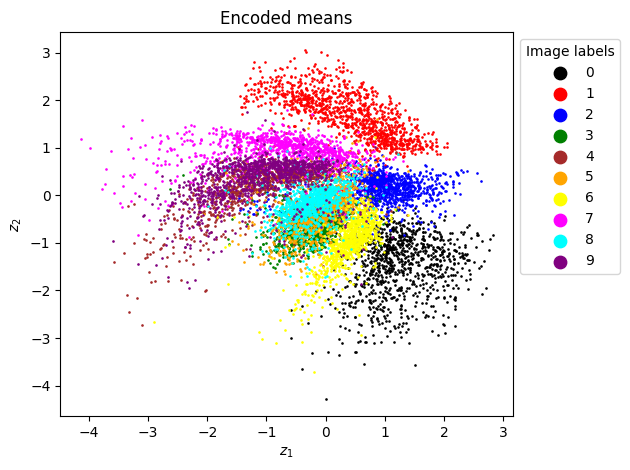

In [9]:
means_plot, labels = vae.encode_means(model.vae, val_loader)
plot_args = dict(title="Encoded means", xlabel=r"$z_1$", ylabel=r"$z_2$")
model_utils.plot_encoded(means_plot, labels, **plot_args)

# Reconstruction of equally spaced gaussian noise

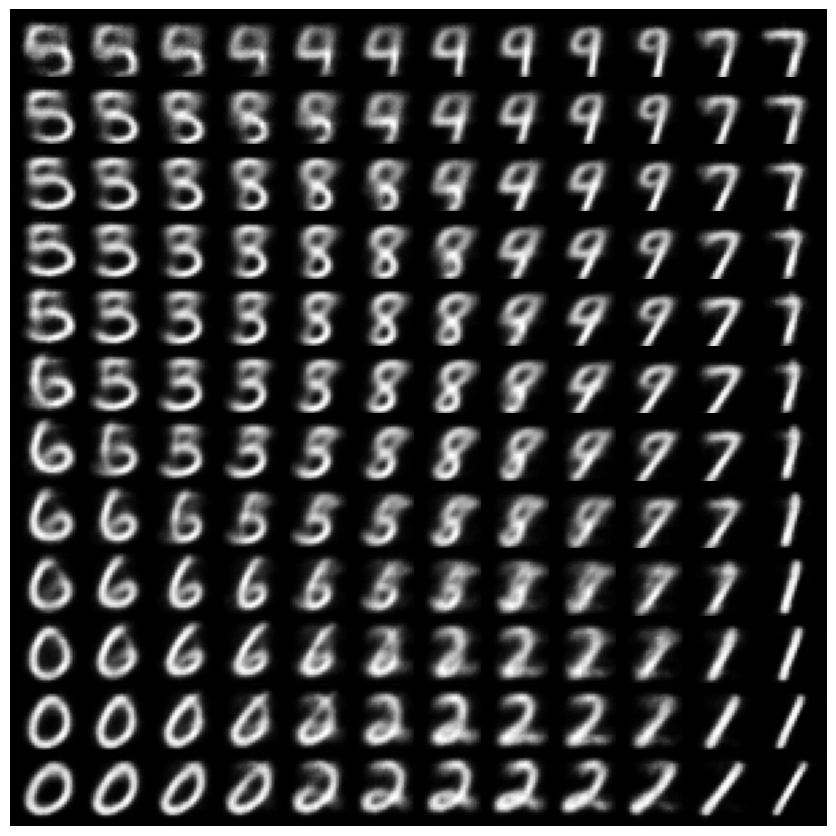

In [10]:
gauss_vals = model_utils.construct_gauss_grid(M=12)
decoded_imgs = model.vae.decode(gauss_vals).detach().numpy()
model_utils.plot_gauss_grid_imgs(decoded_imgs)